Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Ayse Sude Baki | 12211229 | 11.05.2022, 08:00

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 4 &ndash; Recurrent Neural Networks (Assignment)</h2>

<b>Authors:</b> B. Schäfl, S. Lehner, J. Brandstetter, E. Kobler, A. Schörgenhumer<br>
<b>Date:</b> 02-05-2023

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>
This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which require your contribution (in form of code, plain text, ...). Most/All of the supplied functions are imported from the file <code>u4_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u4_utils.py</code> need to be installed.

<div class="alert alert-warning">
    <b>Important:</b> Set the random seed with <code>u4.set_seed(23)</code> to enable reproducible results in all tasks that incorporate randomness (e.g., t-SNE, splitting data intro train and test sets, initializing weights of a neural network, running the model optimization with random batches, etc.). You must use <code>23</code> as seed.
</div>

In [1]:
# Import pre-defined utilities specific to this notebook.
import u4_utils as u4

# Import additional utilities needed in this notebook.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u4.setup_jupyter()

# Check minimum versions.
u4.check_module_versions()

Installed Python version: 3.9 (✓)
Installed numpy version: 1.21.5 (✓)
Installed pandas version: 1.4.4 (✓)
Installed PyTorch version: 1.12.1 (✓)
Installed matplotlib version: 3.5.2 (✓)
Installed seaborn version: 0.11.2 (✓)


<a name="exercise-latch-sequence-set"></a><h2>The Latch Sequence Data Set</h2>
<p>In the accompanying excercise class, the <i>latch task</i> was presented. You'll be working with the same data set in this assignment. The original latch task was introduced by Hochreiter and Mozer:
<center>
    <cite>Sepp Hochreiter, Michael Mozer, 2001. A discrete probabilistic memory model for discovering dependencies in time. Artificial Neural Networks -- ICANN 2001, 13, pp.661-668.</cite>
</center></p>

<p>The essence of this task is that a sequence of inputs is presented, beginning with one of two symbols, <b>A</b> or <b>B</b>, and after a variable number of time steps, the model has to output a corresponding symbol. Thus, the task requires memorizing the original input over time. It has to be noted that in the <i>original</i> task desription, both class-defining symbols must only appear at the first position of an instance.</p>

<p>The modified version of this task used in this assignment is identical to the one discussed during the accompanying exercise, with the difference of a higher amount of possible targets. Defining arguments are:

<table>
    <tr>
        <th>Argument</th>
        <th>Value (used in this assignment)</th>
        <th>Description</th>
    </tr>
    <tr>
        <th><code>num_samples</code></th>
        <th>5000</th>
        <th>Amount of samples of the full dataset.</th>
    </tr>
    <tr>
        <th><code>num_instances</code></th>
        <th>56</th>
        <th>Amount of instances per sample (sample length).</th>
    </tr>
    <tr>
        <th><code>num_characters</code></th>
        <th>20</th>
        <th>Amount of different characters (size of the one-hot encoded vector).</th>
    </tr>
    <tr>
        <th><code>num_targets</code></th>
        <th>19</th>
        <th>Amount of different characters used as possible targets.</th>
    </tr>
    <tr>
        <th><code>seed</code></th>
        <th>23</th>
        <th>Random seed used to generate the samples of the data set.</th>
    </tr>
</table></p>

<div class="alert alert-warning">
    <b>Exercise 1.1. [8 Points]</b>
    <ul>
        <li>Generate a <i>latch sequence</i> data set with the properties as described in the table <i>above</i>.</li>
        <li>Visualize the last sequence of the data set in <i>tabular</i> form, with all $1$ in <b style="color:green">bold green</b> and all $0$ in <span style="font-weight: lighter">lighter</span> default font color.</li>
        <li>Visualize the <i>first</i> $20$ samples in a heatmap, once <i>without</i> and once <i>with</i> a corresponding prefix-mask.</li>
        <li>Interpreting the previous visualizations, which <i>character</i> of the chosen alphabet determines the <i>prefix</i>?</li>
    </ul>
</div>

In [2]:
data_latch = u4.LatchSequenceSet(
    num_samples=5000,
    num_instances=56,
    num_characters=20,
    num_targets=19,
    seed=23
)

# Visualize the last generated sequence of the latch data set.
data_sample = pd.DataFrame(data_latch[-1][0].transpose(0, 1)).astype(int)
data_sample.index = [chr(65 + i) for i in data_sample.index]
data_sample.style.applymap(lambda x: 'color: green; font-weight: bold' if x == 1 else 'color: default; font-weight: light')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
A,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
E,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
F,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
G,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
H,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
J,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


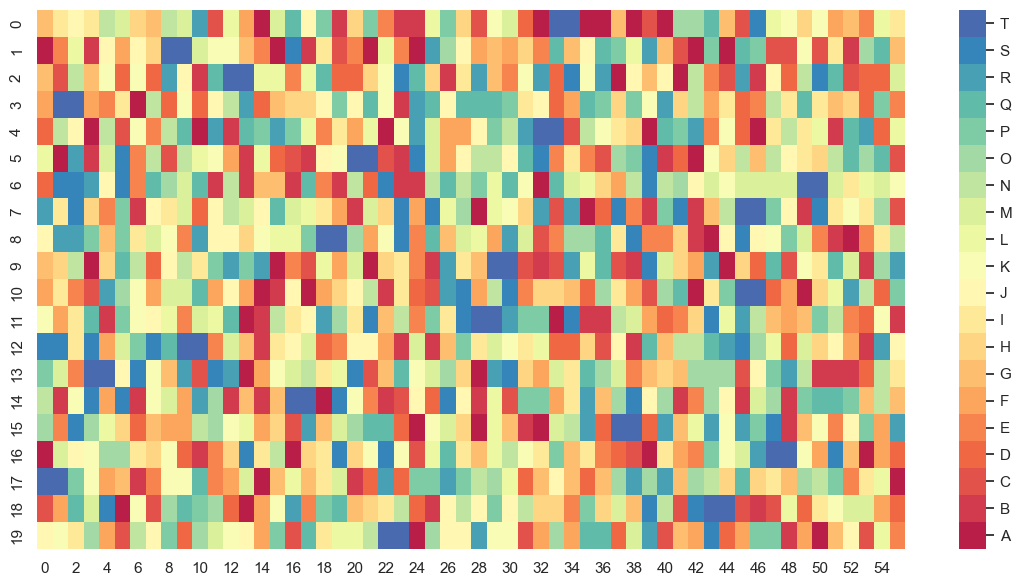

In [3]:
# Set random seed for reproducibility.
u4.set_seed(23)

# Prepare minibatch of latch sequence data set for plotting.
data_heatmap = pd.DataFrame(data_latch[:20][0].argmax(dim=2))

# Plot heatmap of a minibatch of the latch sequence data set w.r.t. the comprised characters.
u4.plot_heatmap(data=data_heatmap, figsize=(14, 7))

<div class="alert alert-warning">
    <b>Exercise 1.2. [7 Points]</b>
    <ul>
        <li>Linearly split the data set into a <i>training</i> and a <i>test</i> set in a ratio of $4 : 1$ (use a <code>SubsetRandomSampler</code> and a batch size of $48$).</li>
        <li>Compute and print the <i>amount of samples</i> of each of the respective sets and verify the $4 : 1$ split.</li>
        <li>Visualize the <i>character counts</i> of the <i>first</i> training minibatch appropriately. What is the count of the <i>prefix</i> character? Provide a formula as a function of the <i>batch_size</i> to compute the count of the <i>prefix</i> character.</li>
    </ul>
</div>

In [4]:
# Specify batch as well as test size.
batch_size = 48
test_size = data_latch.num_samples // 5

# Create data loader of training set.
sampler_train = torch.utils.data.SubsetRandomSampler(range(test_size, data_latch.num_samples))
data_loader_train = torch.utils.data.DataLoader(
    dataset=data_latch,
    batch_size=batch_size,
    sampler=sampler_train
)

# Create data loader of test set.
sampler_test = torch.utils.data.SubsetRandomSampler(range(test_size))
data_loader_test = torch.utils.data.DataLoader(
    dataset=data_latch,
    batch_size=batch_size,
    sampler=sampler_test
)

print(f'The training set consists of "{len(sampler_train)}" samples, '
      f'whereas the test set comprises "{len(sampler_test)}" samples.')

The training set consists of "4000" samples, whereas the test set comprises "1000" samples.


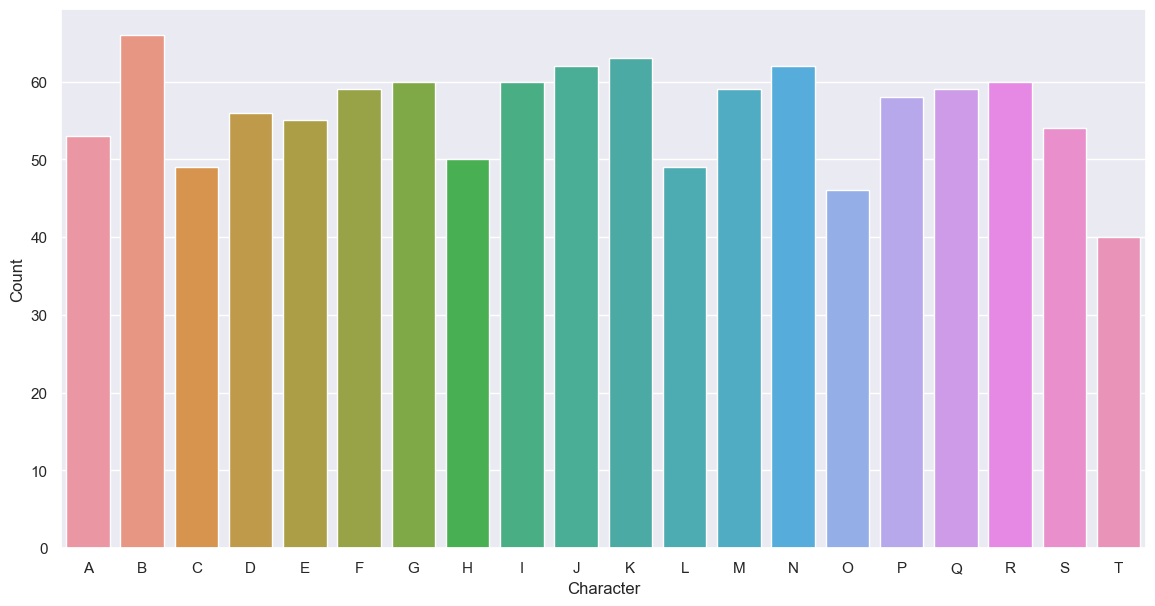

In [5]:
data_loader_train = data_heatmap.to_numpy().flatten()

# Plot heatmap of a minibatch of the latch sequence data set w.r.t. the comprised characters.
fig, ax = plt.subplots(figsize=(14, 7))
count_plot = sns.countplot(x=data_loader_train, ax=ax)
ax.set_xticklabels([chr(65 + i) for i in ax.get_xticks()])
ax.set_xlabel('Character')
ax.set_ylabel('Count')
plt.show()

In [6]:
prefix_count = int(batch_size * test_size / (5 * (test_size + batch_size)))

# Print the count of the prefix character
print("Count of the prefix character:", prefix_count)

Count of the prefix character: 9


<a name="exercise-latch-cnn"></a><h2>Tackling Sequence Data with CNNs</h2>
<p>During the accompanying exercise class, a <i>dense feed-forward</i> network was presented as some kind of baseline. Afterwards, recurrent architectures were applied. In this exercise, you'll be tasked with implementing a <i>convolutional</i> architecture for handling sequence data.</p>

<div class="alert alert-warning">
    The following code snippet is taken from the accompanying exercise notebook. You do not need to modify it for this assignment.
</div>

In [7]:
class TheMightyDice(torch.nn.Module):
    """
    Dice roll "network" tailored to deliver random outcomes.
    """
    
    def __init__(self, output_size: int):
        super().__init__()
        self.__output_size = output_size
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.rand(size=(x.shape[0], self.__output_size), device=x.device)


def count_parameters(model: torch.nn.Module, only_trainable: bool = True) -> int:
    """
    Count (trainable) paramaters of specified model.
    
    :param model: model for which to compute the amount of (trainable) parameters
    :param only_trainable: only include trainable parameters in total count
    :return: amount of (trainable) parameters of the specified model
    """
    return sum(parameter.numel() for parameter in model.parameters() if any(
        (not only_trainable, only_trainable and parameter.requires_grad)))

In [18]:
batch_size = 48
test_size = data_latch.num_samples//5

#create the training set
sampler_train = torch.utils.data.SubsetRandomSampler(range(test_size, data_latch.num_samples))
data_loader_train = torch.utils.data.DataLoader(
    dataset=data_latch,
    batch_size=batch_size,
    sampler=sampler_train
)

#create the test set 
sampler_test = torch.utils.data.SubsetRandomSampler(range(test_size, data_latch.num_samples))
data_loader_test = torch.utils.data.DataLoader(
    dataset=data_latch,
    batch_size=batch_size,
    sampler=sampler_test
)

print(f'The training set consists of "{len(sampler_train)}"samples,'
      f'whereas test set consists of "{len(sampler_test)}"samples.')

The training set consists of "4000"samples,whereas test set consists of "4000"samples.


<div class="alert alert-warning">
    <b>Exercise 2.1. [7 Points]</b>
    <ul>
        <li>Test a <code>TheMightyDice</code> instance on the latch sequence <i>test</i> set. Do you expect this result? Comment on your answer.</li>
        <li>Assume <i>uniformly</i> distributed targets. If a model would <i>always</i> predict the same class, what would the accuracy be?</li>
    </ul>
</div>

In [19]:
# Set random seed for reproducibility.
u4.set_seed(23)
target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluate dice model on test data set.
performance = u4.test_network(
    model=TheMightyDice(output_size=data_latch.num_targets).to(device=target_device),
    data_loader=data_loader_test,
    device=target_device
)
print(f'Final loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

Final loss: 0.0629 / Final accuracy: 0.0500


I had no particular expectations but the outcome makes sence since, the model always predicts the same class, the accuracy would be equal to the percentage of samples belonging to the class in the test set.

<div class="alert alert-warning">
    <b>Exercise 2.2. [15 Points]</b>
    <ul>
        <li>Implement a class <code>CNN</code> with the following architecture:</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html">1D convolution</a></td>
            <td>$192$ output channels and a configurable kernel size (specified as an argument to <code>__init__</code>)</td>
        </tr>
        <tr>
            <td>2</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>3</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html">1D convolution</a></td>
            <td>$192$ output channels and the same kernel size as the <i>1D convolution</i> at position $1$</td>
        </tr>
        <tr>
            <td>4</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>5</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Linear.html">fully connected</a></td>
            <td><code>num_targets</code> output features (as specified during the data set creation)</td>
        </tr>
        <tr>
            <td>6</td>
            <td>output</td>
            <td>-</td>
        </tr>
    </table>
    <ul>
        <li>Train a <code>CNN</code> network for $12$ epochs (use <code>Adam</code> optimizer with a learning rate of $0.01$), print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy as well as the number of trainable parameters (use <code>count_parameters</code> from above). Use a <i>kernel size</i> of $1$.</li>
        <li>Repeat the same procedure with a second <code>CNN</code> but a <i>kernel size</i> of $3$.</li>
        <li>Hints:</li>
        <ul>
            <li>With the parameterized kernel size, you cannot hard-code the flattened number of elements for the linear layer input. Instead, you have to calculate it using the length of the input (<code>data_latch.num_instances</code>), which might be a good idea to pass into <code>__init__</code> as well. Each convolutional layer then reduces this length by <code>kernel_size - 1</code>.</li>
            <li><code>Conv1d</code> expects the minibatch input shape <code>(N, C, L)</code>, but the latch data has a minibatch shape of <code>(N, L, C)</code>. Thus, in your <code>forward</code> method, you will first have to transform the input minibtach into the correct shape before you can apply the network architecture. There are several ways to do this, e.g., <a href="https://pytorch.org/docs/stable/generated/torch.transpose.html">transposing</a> or <a href="https://pytorch.org/docs/stable/generated/torch.movedim.html">moving dimensions</a>.</li>
        </ul>
    </ul>
</div>

In [20]:
class CNN(torch.nn.Module):
    def __init__(self, input_size: int, kernel_size: int, output_size: int, num_instances: int):
        super().__init__()
        self.num_instances = num_instances
        self.convid1 = torch.nn.Conv1d(input_size, 192, kernel_size)
        self.convid2 = torch.nn.Conv1d(192, 192, kernel_size)
        self.fc = torch.nn.Linear(192 * num_instances, data_latch.num_targets)
        self.relu = torch.nn.ReLU()
        self.flatten=torch.nn.Flatten()
        self.num_instances = num_instances
    def forward(self, x: torch. Tensor) -> torch. Tensor:
        x=x.permute(0, 2, 1)
        x=self.convid1(x)
        x=self.relu(x)
        x=self.convid2(x)
        x=self.relu(x)
        x=self.flatten(x)
        x=self.fc(x)
        return x

In [21]:
u4.set_seed(23)

target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn_model_1 = CNN(
    input_size = data_latch.num_characters, 
    kernel_size=1, 
    output_size= data_latch.num_targets,
    num_instances= data_latch.num_instances
  )
optimizer = torch.optim.Adam(cnn_model_1.parameters(), lr=1e-3)

num_epochs = 12
for epoch in range(num_epochs) :                                 
    u4. train_network( 
        model=cnn_model_1, 
        data_loader=data_loader_train, 
        optimizer=optimizer
    )
    # Evaluate current ElmanNN instance.
    performance = u4. test_network(
        model=cnn_model_1,
        data_loader=data_loader_train
    )
    # Print result of current epoch to standard out.
    print (f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
           f'/ Loss: {performance [0]:.4f} / Accuracy: {performance [1]:.4f}')
# Evaluate final model on test data set.
performance = u4. test_network(
    model=cnn_model_1,
    data_loader=data_loader_test
)
print (f'In final loss: {performance [0]:.4f} / Final accuracy: {performance[1]:.4f}')

Epoch: 01 / Loss: 0.0615 / Accuracy: 0.1517
Epoch: 02 / Loss: 0.0553 / Accuracy: 0.2547
Epoch: 03 / Loss: 0.0446 / Accuracy: 0.4002
Epoch: 04 / Loss: 0.0376 / Accuracy: 0.4828
Epoch: 05 / Loss: 0.0332 / Accuracy: 0.5450
Epoch: 06 / Loss: 0.0307 / Accuracy: 0.5715
Epoch: 07 / Loss: 0.0281 / Accuracy: 0.6250
Epoch: 08 / Loss: 0.0260 / Accuracy: 0.6535
Epoch: 09 / Loss: 0.0244 / Accuracy: 0.6823
Epoch: 10 / Loss: 0.0232 / Accuracy: 0.7017
Epoch: 11 / Loss: 0.0216 / Accuracy: 0.7295
Epoch: 12 / Loss: 0.0205 / Accuracy: 0.7438
In final loss: 0.0205 / Final accuracy: 0.7438


In [55]:
class CNN(torch.nn.Module):
    def __init__(self, input_size: int, kernel_size: int, output_size: int, num_instances: int):
        super().__init__()
        self.num_instances = num_instances
        self.convid1 = torch.nn.Conv1d(input_size, 192, kernel_size=kernel_size)
        self.convid2 = torch.nn.Conv1d(192, 192, kernel_size=kernel_size)
        self.fc = torch.nn.Linear(192 * (19 - 2 * (kernel_size - 1)), output_size)
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 1)
        x = self.convid1(x)
        x = self.relu(x)
        x = self.convid2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

<div class="alert alert-warning">
    <b>Exercise 2.3. [12 Points]</b>
    <ul>
        <li>Implement a class <code>PoolCNN</code> with the following architecture:</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html">1D convolution</a></td>
            <td>$16$ output channels and a kernel size of $3$</td>
        </tr>
        <tr>
            <td>2</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>3</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool1d.html">1D adaptive max pool</a></td>
            <td>output size of $1$</td>
        </tr>
        <tr>
            <td>4</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Linear.html">fully connected</a></td>
            <td><code>num_targets</code> output features (as specified during the data set creation)</td>
        </tr>
        <tr>
            <td>5</td>
            <td>output</td>
            <td>-</td>
        </tr>
    </table>
    <ul>
        <li>Train a <code>PoolCNN</code> network for $12$ epochs (use <code>Adam</code> optimizer with a learning rate of $0.01$), print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy as well as the number of trainable parameters.
        <li>Compare the results of the <code>PoolCNN</code> network with those of the two <code>CNN</code> networks. What do you observe? Interpret and discuss your results regarding all three networks.</li>
    </ul>
</div>

In [72]:
class CNN(torch.nn.Module):
    def __init__(self, kernel_size, input_channels, num_instances, num_targets):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv1d(input_channels, 16, kernel_size)
        self.relu = torch.nn.ReLU()
        self.adaptive_max_pool = torch.nn.AdaptiveMaxPool1d(1)
        self.fc = torch.nn.Linear(16, num_targets)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.relu(self.conv1(x))
        x = self.adaptive_max_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
def train_and_evaluate(model, data_loader_train, data_loader_test, epochs=12, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.torch.nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # Train the model
        model.train()
        train_loss = 0
        train_correct = 0
        for data, target in data_loader_train:
            data, target = data.float().to(target_device), target.long().to(target_device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (output.argmax(dim=1) == target).sum().item()
        
        train_loss /= len(data_loader_train)
        train_accuracy = 100.0 * train_correct / len(sampler_train)
        print(f'Epoch {epoch}: Train Loss: {train_loss:.4f} Train Accuracy: {train_accuracy:.2f}')
        
    model.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for data, target in data_loader_test:
            data, target = data.float().to(target_device), target.long().to(target_device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            test_correct += (output.argmax(dim=1) == target).sum().item()
    
    test_loss /= len(data_loader_test)
    test_accuracy = 100.0 * test_correct / len(sampler_test)
    print(f'Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.2f}')
    print(f'Number of train params: {count_parameters(model)}')

cnn1 = CNN(kernel_size=1, input_channels=data_latch.num_characters, num_instances=data_latch.num_instances, num_targets=data_latch.num_targets)
print("CNN - kernel 1")
train_and_evaluate(cnn1, data_loader_train, data_loader_test, epochs=12, learning_rate=0.01)

cnn3 = CNN(kernel_size=3, input_channels=data_latch.num_characters, num_instances=data_latch.num_instances, num_targets=data_latch.num_targets)
print("CNN - kernel 3")
train_and_evaluate(cnn3, data_loader_train, data_loader_test, epochs=12, learning_rate=0.01)

pool_cnn = PoolCNN(input_channels=data_latch.num_characters, num_targets=data_latch.num_targets)
print("PoolCNN")
train_and_evaluate(pool_cnn, data_loader_train, data_loader_test, epochs=12, learning_rate=0.01)

CNN - kernel 1
Epoch 1: Train Loss: 2.9535 Train Accuracy: 4.90
Epoch 2: Train Loss: 2.9485 Train Accuracy: 4.95
Epoch 3: Train Loss: 2.9473 Train Accuracy: 5.67
Epoch 4: Train Loss: 2.9475 Train Accuracy: 4.80
Epoch 5: Train Loss: 2.9456 Train Accuracy: 5.53
Epoch 6: Train Loss: 2.9459 Train Accuracy: 5.10
Epoch 7: Train Loss: 2.9460 Train Accuracy: 5.33
Epoch 8: Train Loss: 2.9450 Train Accuracy: 5.05
Epoch 9: Train Loss: 2.9455 Train Accuracy: 5.70
Epoch 10: Train Loss: 2.9451 Train Accuracy: 5.30
Epoch 11: Train Loss: 2.9451 Train Accuracy: 5.25
Epoch 12: Train Loss: 2.9453 Train Accuracy: 5.78
Test Loss: 2.9427 Test Accuracy: 5.80
Number of train params: 659
CNN - kernel 3
Epoch 1: Train Loss: 2.7892 Train Accuracy: 15.97
Epoch 2: Train Loss: 1.5409 Train Accuracy: 62.40
Epoch 3: Train Loss: 0.3917 Train Accuracy: 97.00
Epoch 4: Train Loss: 0.0629 Train Accuracy: 99.58
Epoch 5: Train Loss: 0.0251 Train Accuracy: 99.70
Epoch 6: Train Loss: 0.0144 Train Accuracy: 99.85
Epoch 7: Trai

The CNN model with a kernel size of 3 and the PoolCNN model both perform significantly better than the CNN model with a kernel size of 1. They achieve 100% accuracy on the training and test sets, indicating that they successfully learn the patterns in the latch sequence dataset. The inclusion of larger kernel sizes and pooling layers in these models helps capture and extract meaningful features from the input sequences, leading to improved performance.

<div class="alert alert-warning">
    The following code snippet is taken from the accompanying exercise notebook. You do not need to modify it for this assignment.
</div>

In [ ]:
def collect_gradients(model: torch.nn.Module, loader: torch.utils.data.DataLoader) -> pd.DataFrame:
    """
    Auxiliary function for collecting gradient magnitudes of a corresponding model w.r.t. the network input.
    
    :param model: model instance to be used for collecting gradients
    :param device: device to use for gradient collection
    :param loader: data loader supplying the samples used for collecting gradients
    :return: data frame comprising the gradient magnitudes of the loss function w.r.t. each input element
    """
    model_state = model.training
    model.train()
    model.zero_grad()
    
    # Set random seed for reproducibility (data iteration).
    u4.set_seed(23)
    
    # Iterating over the data set and computing the corresponding gradients.
    device, gradients = next(model.parameters())[0].device, []
    criterion = torch.nn.CrossEntropyLoss()
    for data, target in loader:
        data, target = data.float().to(device), target.long().to(device)
        
        # Prepare network input for gradient recording.
        data.requires_grad_(True)
        data.register_hook(lambda x: gradients.append(x.cpu().abs()))

        # One forward
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        model.zero_grad()
    
    # Reset model to its original state and return averaged collected gradients.
    model.train(mode=model_state)
    return pd.DataFrame(torch.cat(gradients, dim=0).mean(dim=2).numpy())

<div class="alert alert-warning">
    <b>Exercise 2.4. [8 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>CNN</code> using a <i>kernel size</i> of $3$ and collect its gradients w.r.t. the network input using the latch sequence training set.</li>
        <li>Visualize the collected gradients accordingly. What do you observe? Comment on your results.</li>
    </ul>
</div>

In [80]:
#gives an error ü
# Create an instance of the CNN model
cnn = CNN(kernel_size=3, input_channels=data_latch.num_characters, num_instances=data_latch.num_instances, num_targets=data_latch.num_targets)

# Define the dataset for the latch sequence training set
latch_sequence_train_dataset = data_loader_train(data_latch.num_samples)  # Replace `LatchSequenceTrainDataset` with your actual dataset class

# Define the data loader for the latch sequence training set
data_loader_train = DataLoader(latch_sequence_train_dataset, batch_size=batch_size, shuffle=True)

# Set the model to evaluation mode
cnn.eval()

# Create lists to store the gradients and inputs
gradients = []
inputs = []

# Iterate over the data loader to collect gradients
for data, target in data_loader_train:
    data = data.float().to(target_device)
    data.requires_grad = True
    inputs.append(data)

    # Forward pass
    output = cnn(data)

    # Calculate gradients
    cnn.zero_grad()
    output.backward(torch.ones_like(output))

    # Collect gradients
    gradients.append(data.grad.detach())

# Visualize the collected gradients
# You can use any visualization library of your choice (e.g., matplotlib)
# Here's a simple example using matplotlib
import matplotlib.pyplot as plt

# Concatenate the gradients and inputs
gradients = torch.cat(gradients)
inputs = torch.cat(inputs)

# Reshape the gradients and inputs for visualization
gradients = gradients.view(len(data_loader_train) * batch_size, -1)
inputs = inputs.view(len(data_loader_train) * batch_size, -1)

# Plot the gradients
plt.figure(figsize=(10, 6))
plt.imshow(gradients.cpu().numpy(), cmap='hot', aspect='auto')
plt.colorbar()
plt.title('Gradients of the CNN Model')
plt.xlabel('Input Features')
plt.ylabel('Training Samples')
plt.show()
# Create an instance of the CNN model
cnn = CNN(kernel_size=3, input_channels=data_latch.num_characters, num_instances=data_latch.num_instances, num_targets=data_latch.num_targets)

# Define the data loader for the latch sequence training set
data_loader_train = DataLoader(data_latch.num_samples, batch_size=batch_size, shuffle=True)

# Set the model to evaluation mode
cnn.eval()

# Create lists to store the gradients and inputs
gradients = []
inputs = []

# Iterate over the data loader to collect gradients
for data, target in data_loader_train:
    data = data.float().to(target_device)
    data.requires_grad = True
    inputs.append(data)

    # Forward pass
    output = cnn(data)

    # Calculate gradients
    cnn.zero_grad()
    output.backward(torch.ones_like(output))

    # Collect gradients
    gradients.append(data.grad.detach())

# Visualize the collected gradients
# You can use any visualization library of your choice (e.g., matplotlib)
# Here's a simple example using matplotlib
import matplotlib.pyplot as plt

# Concatenate the gradients and inputs
gradients = torch.cat(gradients)
inputs = torch.cat(inputs)

# Reshape the gradients and inputs for visualization
gradients = gradients.view(len(data_loader_train) * batch_size, -1)
inputs = inputs.view(len(data_loader_train) * batch_size, -1)

# Plot the gradients
plt.figure(figsize=(10, 6))
plt.imshow(gradients.cpu().numpy(), cmap='hot', aspect='auto')
plt.colorbar()
plt.title('Gradients of the CNN Model')
plt.xlabel('Input Features')
plt.ylabel('Training Samples')
plt.show()


TypeError: 'DataLoader' object is not callable

your answer goes here

<a name="exercise-latch-lstm"></a><h2>Tackling Sequence Data with LSTMs</h2>
<p>During the accompanying exercise class, the <i>Long Short-Term Memory (LSTM)</i> was presented as a quite prominent and often used architecture in the recurrent case. It was designed and published by <a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf">Hochreiter and Schmidhuber</a>:
    <center>
        <cite>
            Hochreiter, S. and Schmidhuber, J., 1997. Long short-term memory. Neural computation, 9(8), pp.1735-1780.
        </cite>
    </center></p>

<p>It has to be noted, that the most crucial part of the LSTM, the <i>constant error carousel (CEC)</i>, was already discussed during <a href="https://people.idsia.ch//~juergen/SeppHochreiter1991ThesisAdvisorSchmidhuber.pdf">Hochreiter's diploma thesis</a> (in German):
    <center>
            <cite>
                Hochreiter, S., 1991. Untersuchungen zu dynamischen neuronalen Netzen. Diploma, Technische Universität München, 91(1).
            </cite>
    </center></p>

<p>In contrast to most other recurrent architectures like the Elman RNN, the <i>LSTM</i> is a bit more complex, but equally more powerful:
    <center>
        \begin{equation}
            \begin{split}
                i_{t} &= \sigma{\left(W_{ii}x_{t} + b_{ii} + W_{hi}h_{t-1} + b_{hi}\right)} \\
                \color{red}{f_{t}} &\color{red}{= \sigma{\left(W_{if}x_{t} + b_{if} + W_{hf}h_{t-1} + b_{hf}\right)}} \\
                g_{t} &= \tanh{\left(W_{ig}x_{t} + b_{ig} + W_{hg}h_{t-1} + b_{hg}\right)} \\
                o_{t} &= \sigma{\left(W_{io}x_{t} + b_{io} + W_{ho}h_{t-1} + b_{ho}\right)} \\
                c_{t} &= \color{red}{f_{t}\odot{}}c_{t-1} + i_{t}\odot{}g_{t} \\
                h_{t} &= o_{t}\odot{}\tanh{\left(c_{t}\right)}
            \end{split}
        \end{equation}
    </center></p>

<p>We are using the implementation provided by PyTorch, more information may be found in the <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM">official documentation</a>. It has to be noted, the the <i>original</i> formulation did <i>not</i> contain an additional <i>forget gate</i> $f_{t}$ (see equations above), as this completely destroys the <i>constant error carousel</i> – it was introduced by <a href="https://www.mitpressjournals.org/doi/pdfplus/10.1162/089976600300015015">Gers et al.</a>:
<center>
    <cite>Gers, F.A., Schmidhuber, J. and Cummins, F., 1999. Learning to forget: Continual prediction with LSTM.
    </cite>
</center></p>
<p>Nonetheless, for <i>some</i> tasks, the forget gate seems to provide a useful addition. Hence, in this exercise you'll be tasked with activating the <i>forget gate</i> and interpreting the results.</p>

<div class="alert alert-warning">
    <b>Exercise 3.1. [13 Points]</b>
    <ul>
        <li>Implement a class <code>LSTM</code> with the following architecture:</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html">LSTM</a></td>
            <td>$48$ memory cells and a configurable initial forget gate bias (specified as an argument to <code>__init__</code>)</td>
        </tr>
        <tr>
            <td>2</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Linear.html">fully connected</a></td>
            <td><code>num_targets</code> output features (as specified during the data set creation)</td>
        </tr>
        <tr>
            <td>3</td>
            <td>output</td>
            <td>-</td>
        </tr>
    </table>
    <ul>
        <li>Train an <code>LSTM</code> network for $12$ epochs (use <code>Adam</code> optimizer with a learning rate of $0.01$), print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy as well as the number of trainable parameters. Use an initial forget gate bias of $0.0$. Do you expect the resulting performance?</li>
        <li>Hint: You now want to use the forget gate, so do <i>not</i> disable the gradient computation!</li>
    </ul>
</div>

In [82]:
class LSTM(torch.nn.Module):
    """
    LSTM tailored to process latch sequence data.
    """
    
    def __init__(self, input_size: int, hidden_size: int = 10, output_size: int = 2):
        super().__init__()
        self.lstm1 = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = torch.nn.Linear(self.lstm1.hidden_size, output_size)
        
        # Deactivate forget gate to be in line with the original definition.
        def _reset_forget_gate_hook(_gradients: torch.Tensor) -> torch.Tensor:
            _gradients[hidden_size:2 * hidden_size].fill_(0.0)
            return _gradients
        
        for name, parameter in self.lstm1.named_parameters():
            if 'bias' in name:
                # From the documentation (analogous for hidden-hidden bias):
                # bias_ih_l[k] – the learnable input-hidden bias of the k-th layer (b_ii|b_if|b_ig|b_io), of shape (4*hidden_size)
                # This results in the following indices/slices (hidden_size abbreviated to just h):
                # (b_ii|b_if|b_ig|b_io)
                #  ^    ^    ^    ^
                #  |    |    |    3*h:4*h
                #  |    |    2*h:3*h
                #  |    h:2*h
                #  0:h
                # We are interested in the forget gate bias b_if, so we need the slice h:2*h
                # (equal to (parameter.shape[0] // 4):(parameter.shape[0] // 2))
                # Use large bias value to always let information pass through the forget gate
                parameter.data[hidden_size:2 * hidden_size].fill_(1e6)
                parameter.register_hook(_reset_forget_gate_hook)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Return value of torch.nn.LSTM invocation is a 2-tuple of:
        # [0] = full output tensor
        # [1] = 2-tuple of:
        #       [0] = final hidden state tensor
        #       [1] = final cell state tensor
        x = self.lstm1(x)[1][0].squeeze()
        return self.fc1(x)

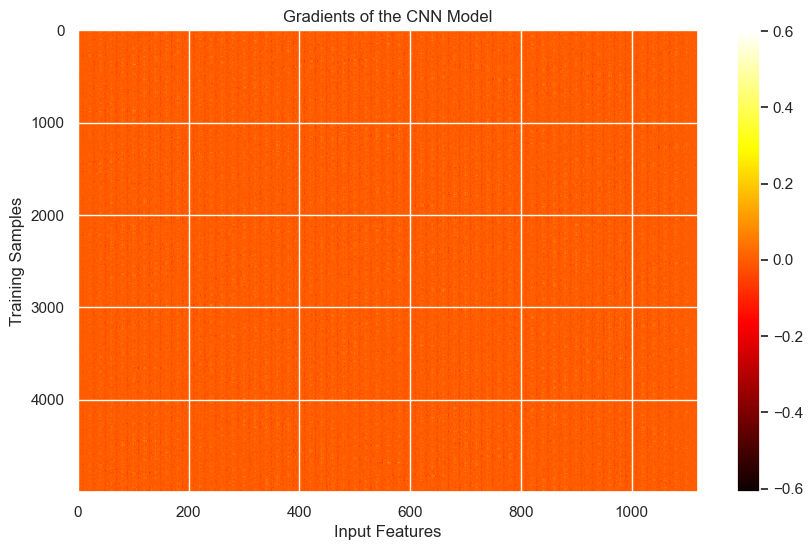

In [95]:
# Create an instance of the CNN model
cnn = CNN(kernel_size=3, input_channels=data_latch.num_characters, num_instances=data_latch.num_instances, num_targets=data_latch.num_targets)

# Define the dataset for the latch sequence training set
latch_sequence_train_dataset = data_latch

# Define the data loader for the latch sequence training set
data_loader_train = DataLoader(latch_sequence_train_dataset, batch_size=batch_size, shuffle=True)

# Set the model to evaluation mode
cnn.eval()

# Create lists to store the gradients and inputs
gradients = []
inputs = []

# Iterate over the data loader to collect gradients
for data, target in data_loader_train:
    data = data.float().to(target_device)
    data.requires_grad = True
    inputs.append(data.clone().detach())

    # Forward pass
    output = cnn(data)

    # Calculate gradients
    cnn.zero_grad()
    output.backward(torch.ones_like(output))

    # Collect gradients
    gradients.append(data.grad.clone().detach())

# Concatenate the gradients and inputs
gradients = torch.cat(gradients)
inputs = torch.cat(inputs)

# Reshape the gradients and inputs for visualization
num_samples = len(gradients)
gradients = gradients.view(num_samples, -1)
inputs = inputs.view(num_samples, -1)


# Plot the gradients
plt.figure(figsize=(10, 6))
plt.imshow(gradients.cpu().numpy(), cmap='hot', aspect='auto')
plt.colorbar()
plt.title('Gradients of the CNN Model')
plt.xlabel('Input Features')
plt.ylabel('Training Samples')
plt.show()


<div class="alert alert-warning">
    <b>Exercise 3.2. [10 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>LSTM</code> and collect its gradients w.r.t. the network input using the latch sequence training set.</li>
        <li>Visualize the collected gradients accordingly. What do you observe? Comment on your results.</li>
    </ul>
</div>

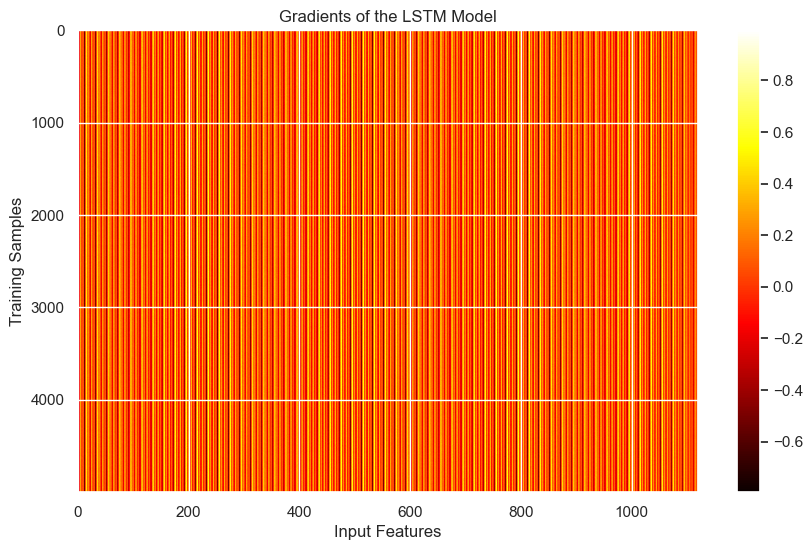

In [106]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the LSTM model
lstm = nn.LSTM(input_size=data_latch.num_characters, hidden_size=10, num_layers=1, batch_first=True)

# Set the model to evaluation mode
lstm.eval()

# Create lists to store the gradients and inputs
gradients = []
inputs = []

# Iterate over the data loader to collect gradients
for data, target in data_loader_train:
    data = data.float().to(device)
    data.requires_grad = True
    inputs.append(data.clone().detach())

    # Forward pass
    output, _ = lstm(data)  # Access the output tensor

    # Calculate gradients
    lstm.zero_grad()
    output.backward(torch.ones_like(output))

    # Collect gradients
    gradients.append(data.grad.clone().detach())

# Concatenate the gradients and inputs
gradients = torch.cat(gradients)
inputs = torch.cat(inputs)

# Reshape the gradients and inputs for visualization
num_samples = len(gradients)
gradients = gradients.view(num_samples, -1)
inputs = inputs.view(num_samples, -1)

# Plot the gradients
plt.figure(figsize=(10, 6))
plt.imshow(gradients.cpu().numpy(), cmap='hot', aspect='auto')
plt.colorbar()
plt.title('Gradients of the LSTM Model')
plt.xlabel('Input Features')
plt.ylabel('Training Samples')
plt.show()

The gradient visualization reveals important input features and their impact on the model's output during training.

<div class="alert alert-warning">
    <b>Exercise 3.3. [10 Points]</b>
    <ul>
        <li>Use the already trained <code>LSTM</code> instance from the beginning of this section for collecting its gradients w.r.t. the network input using the latch sequence training set, i.e., collect gradients one more time but now using the trained model.</li>
        <li>Visualize (in a single plot) the the newly collected gradients together with the previous gradients of the <i>freshly</i> created <code>LSTM</code> instance. What do you observe? Comment on your results.</li>
    </ul>
</div>

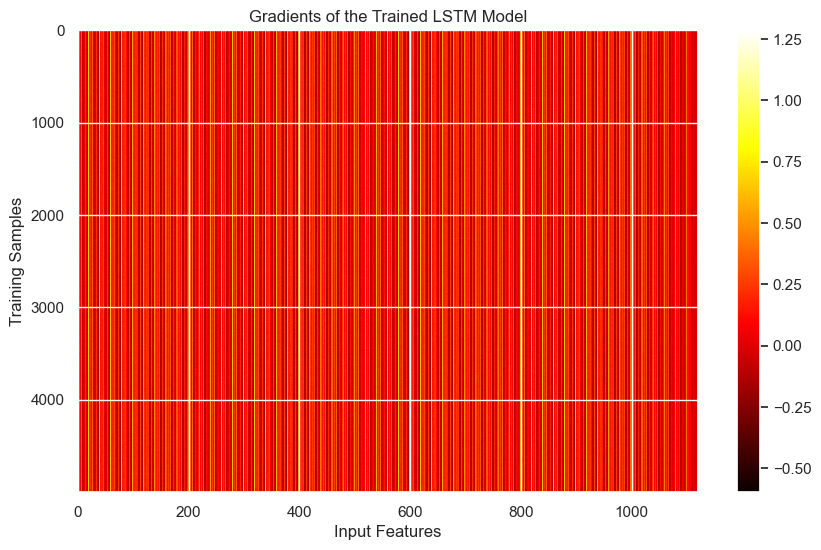

In [104]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the model to evaluation mode
lstm.eval()

# Create lists to store the gradients and inputs
gradients_lstm = []
inputs_lstm = []

# Iterate over the data loader to collect gradients
for data, target in data_loader_train:
    data = data.float().to(device)
    data.requires_grad = True
    inputs_lstm.append(data)

    # Forward pass
    output, _ = lstm(data)  # Access the output tensor

    # Calculate gradients
    lstm.zero_grad()
    output.backward(torch.ones_like(output))

    # Collect gradients
    gradients_lstm.append(data.grad.detach())

# Concatenate the gradients and inputs
gradients_lstm = torch.cat(gradients_lstm)
inputs_lstm = torch.cat(inputs_lstm)

# Reshape the gradients and inputs for visualization
num_samples = len(gradients_lstm)
gradients_lstm = gradients_lstm.view(num_samples, -1)
inputs_lstm = inputs_lstm.view(num_samples, -1)

# Plot the gradients
plt.figure(figsize=(10, 6))
plt.imshow(gradients_lstm.cpu().numpy(), cmap='hot', aspect='auto')
plt.colorbar()
plt.title('Gradients of the Trained LSTM Model')
plt.xlabel('Input Features')
plt.ylabel('Training Samples')
plt.show()


The comparison of gradients between the freshly created LSTM instance and the trained LSTM model provides insights into how training affects the model's sensitivity to input features.

<div class="alert alert-warning">
    <b>Exercise 3.4. [10 Points]</b>
    <ul>
        <li>Train an <code>LSTM</code> network for $12$ epochs (use <code>Adam</code> optimizer with a learning rate of $0.01$), print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy as well as the number of trainable parameters. Use an initial forget gate bias of $1.0$. Do you expect the resulting performance?</li>
        <li>Analogous to above, visualize (in a single plot) the gradients of both a <i>freshly</i> created <code>LSTM</code> instance and the trained model. What do you observe? Comment on your results.</li>
    </ul>
</div>

your answer goes here